In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
%matplotlib inline

In [ ]:
!conda install geopandas

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: \ 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - conda-forge/noarch::seaborn-base==0.11.1=pyhd8ed1ab_1
  - conda-forge/noarch::nbclassic==0.2.6=pyhd8ed1ab_0
  - conda-forge/linux-64::blaze==0.11.3=py36_0
  - conda-forge/linux-64::matplotlib==3.3.4=py36h5fab9bb_0
  - defaults/linux-64::_anaconda_depends==5.1.0=py36_2
  - conda-forge/noarch::jupyterlab==3.0.9=pyhd8ed1ab_0
  - conda-forge/noarch::python-language-server==0.36.2=pyhd8ed1ab_0
  - conda-forge/noarch::jupyterlab_server==2.3.0=pyhd8ed1ab_0
  - conda-forge/noarch::pyls-black==0.4.6=pyh9f0ad1d_0
  - conda-forge/linux-64::scikit-image==0.16.2=py36hb3f55d8_0
  - conda-forge/noarch::black==20.8b1=py_1
  - conda-forge/linux-64::anyio==2.1.

In [ ]:
import geopandas

In [14]:
data = pd.read_csv('ufo_fullset.csv', usecols=['latitude', 'longitude', 'researchOutcome'])
explained = data[data.researchOutcome == 'explained']
unexplained = data[data.researchOutcome == 'unexplained']
probable = data[data.researchOutcome == 'probable']
locations = data[data.researchOutcome != 'explained']

print(f"Total observations:  {data.shape[0]}")
print(f"Explained observations:  {explained.shape[0]}, {int(100*explained.shape[0]/data.shape[0])}%")
print(f"Unexplained observations:  {unexplained.shape[0]}, {int(100*unexplained.shape[0]/data.shape[0])}%")
print(f"Probable observations:  {probable.shape[0]}, {int(100*probable.shape[0]/data.shape[0])}%")
print(f"Used observations:  {locations.shape[0]}, {int(100*locations.shape[0]/data.shape[0])}%")


Total observations:  18000
Explained observations:  12822, 71%
Unexplained observations:  3308, 18%
Probable observations:  1870, 10%
Used observations:  5178, 28%


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   latitude         18000 non-null  float64
 1   longitude        18000 non-null  float64
 2   researchOutcome  18000 non-null  object 
dtypes: float64(2), object(1)
memory usage: 422.0+ KB


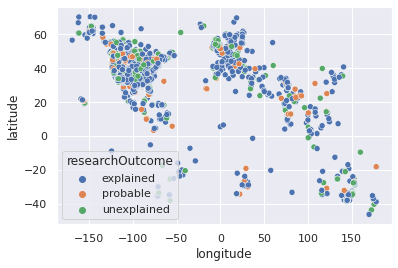

In [18]:
ax = sns.scatterplot(data=data, x='longitude', y='latitude', hue='researchOutcome')

In [20]:
import geopandas


ModuleNotFoundError: No module named 'geopandas'